In [37]:
import os
import gc
import optuna
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [38]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [39]:
df = train_df.append(test_df).reset_index(drop = True)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [40]:
#df.loc[df['location'].astype(str).str.contains('Afyon')]

In [41]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

In [42]:
skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 12)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


(66274, 80)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu,total_experience,last_experience,nunique_company,avg_days_to_quit,company_id,company_avg_days_to_quit
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1341.0,306.0,3.0,447.000000,26.0,912.280537
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2101.0,699.0,4.0,525.250000,1337.0,393.769231
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1826.0,610.0,4.0,456.500000,4366.0,NaN
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,1553.0,1.0,3409.000000,26.0,912.280537
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,640.0,3.0,1136.333333,1562.0,837.166667


In [43]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 79)
test_set: (13255, 79)


In [44]:
# CatBoost Parameters
params = {'one_hot_max_size': 179, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds)


In [45]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6399891	test: 0.6409415	best: 0.6409415 (0)	total: 191ms	remaining: 15m 52s
200:	learn: 0.8518854	test: 0.7474256	best: 0.7477651 (182)	total: 29.1s	remaining: 11m 35s
400:	learn: 0.9067267	test: 0.7588548	best: 0.7588548 (400)	total: 58.1s	remaining: 11m 6s
600:	learn: 0.9334571	test: 0.7656444	best: 0.7668892 (572)	total: 1m 27s	remaining: 10m 40s
800:	learn: 0.9521525	test: 0.7682471	best: 0.7682471 (799)	total: 1m 56s	remaining: 10m 12s
1000:	learn: 0.9636051	test: 0.7692656	best: 0.7701709 (833)	total: 2m 25s	remaining: 9m 39s
1200:	learn: 0.9718664	test: 0.7689261	best: 0.7701709 (833)	total: 2m 53s	remaining: 9m 8s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7701708725
bestIteration = 833

Shrink model to first 834 iterations.


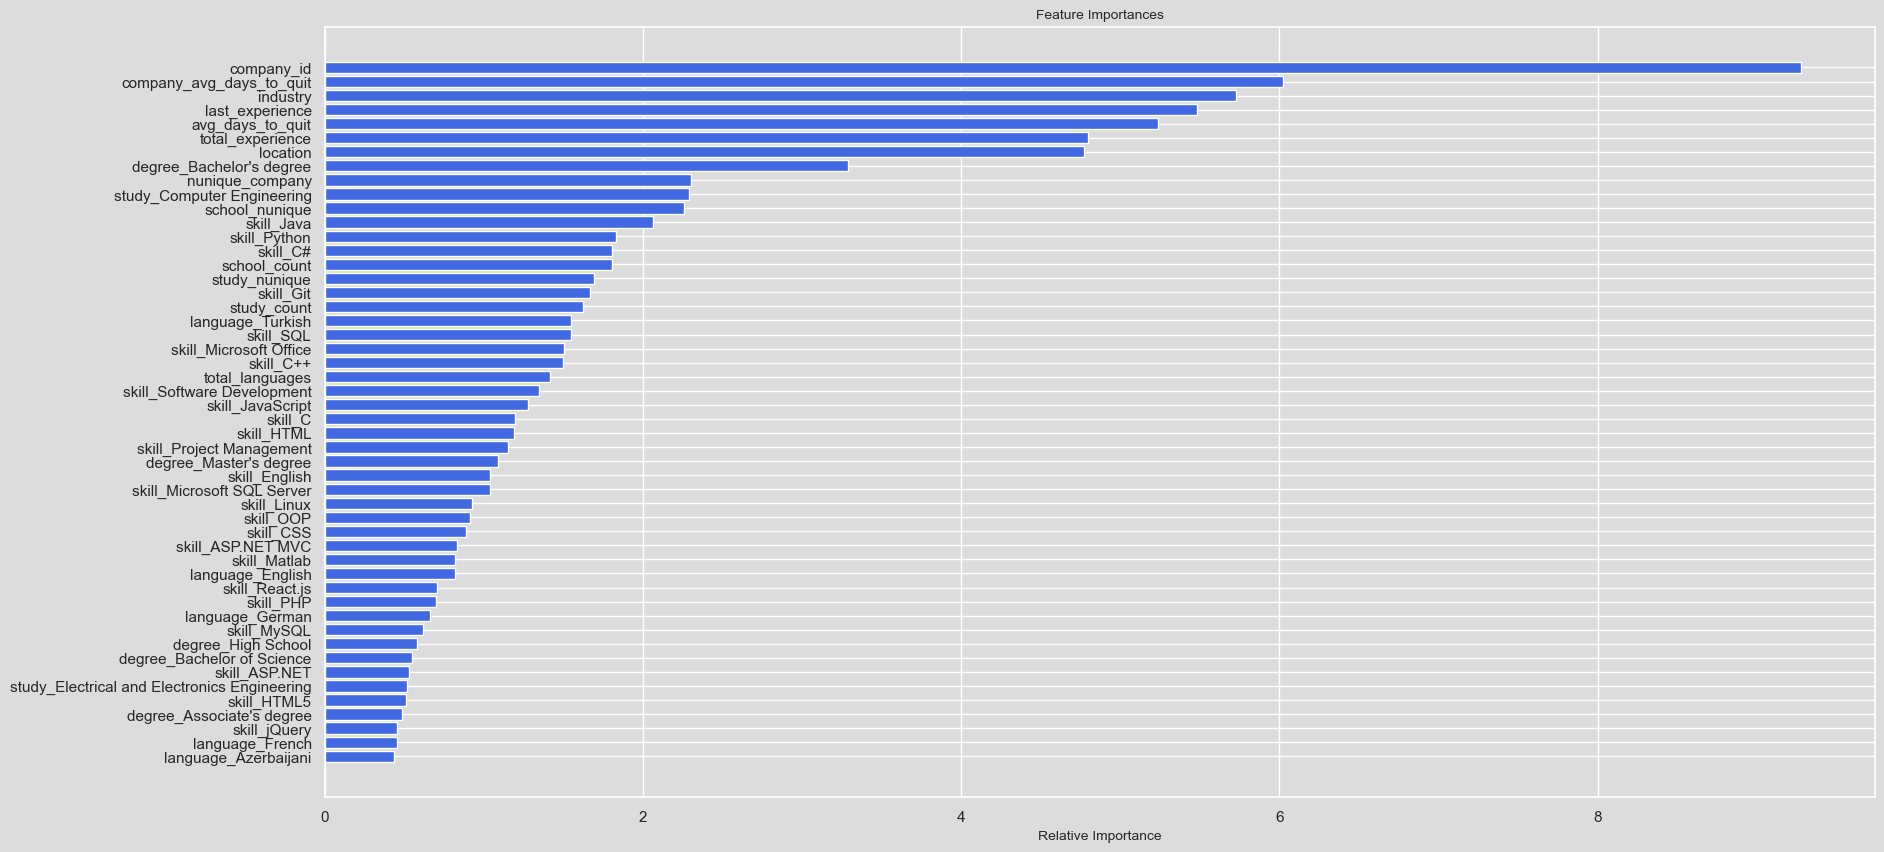

fold accuracy: 0.7701708724680322
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6448327	test: 0.6418468	best: 0.6418468 (0)	total: 203ms	remaining: 16m 54s
200:	learn: 0.8503010	test: 0.7548942	best: 0.7554600 (192)	total: 28.7s	remaining: 11m 26s
400:	learn: 0.9029243	test: 0.7643997	best: 0.7645128 (398)	total: 58.2s	remaining: 11m 7s
600:	learn: 0.9302205	test: 0.7685866	best: 0.7690393 (552)	total: 1m 26s	remaining: 10m 36s
800:	learn: 0.9492327	test: 0.7726604	best: 0.7737920 (775)	total: 1m 55s	remaining: 10m 7s
1000:	learn: 0.9619755	test: 0.7740183	best: 0.7749236 (909)	total: 2m 24s	remaining: 9m 35s
1200:	learn: 0.9703952	test: 0.7779790	best: 0.7785448 (1175)	total: 2m 52s	remaining: 9m 5s
1400:	learn: 0.9770495	test: 0.7792237	best: 0.7806948 (1367)	total: 3m 20s	remaining: 8m 35s
1600:	learn: 0.9820289	test: 0.7791106	best: 0.7806948 (1367)	total: 3m 50s	remaining: 8m 9s
Stopped by overfitting det

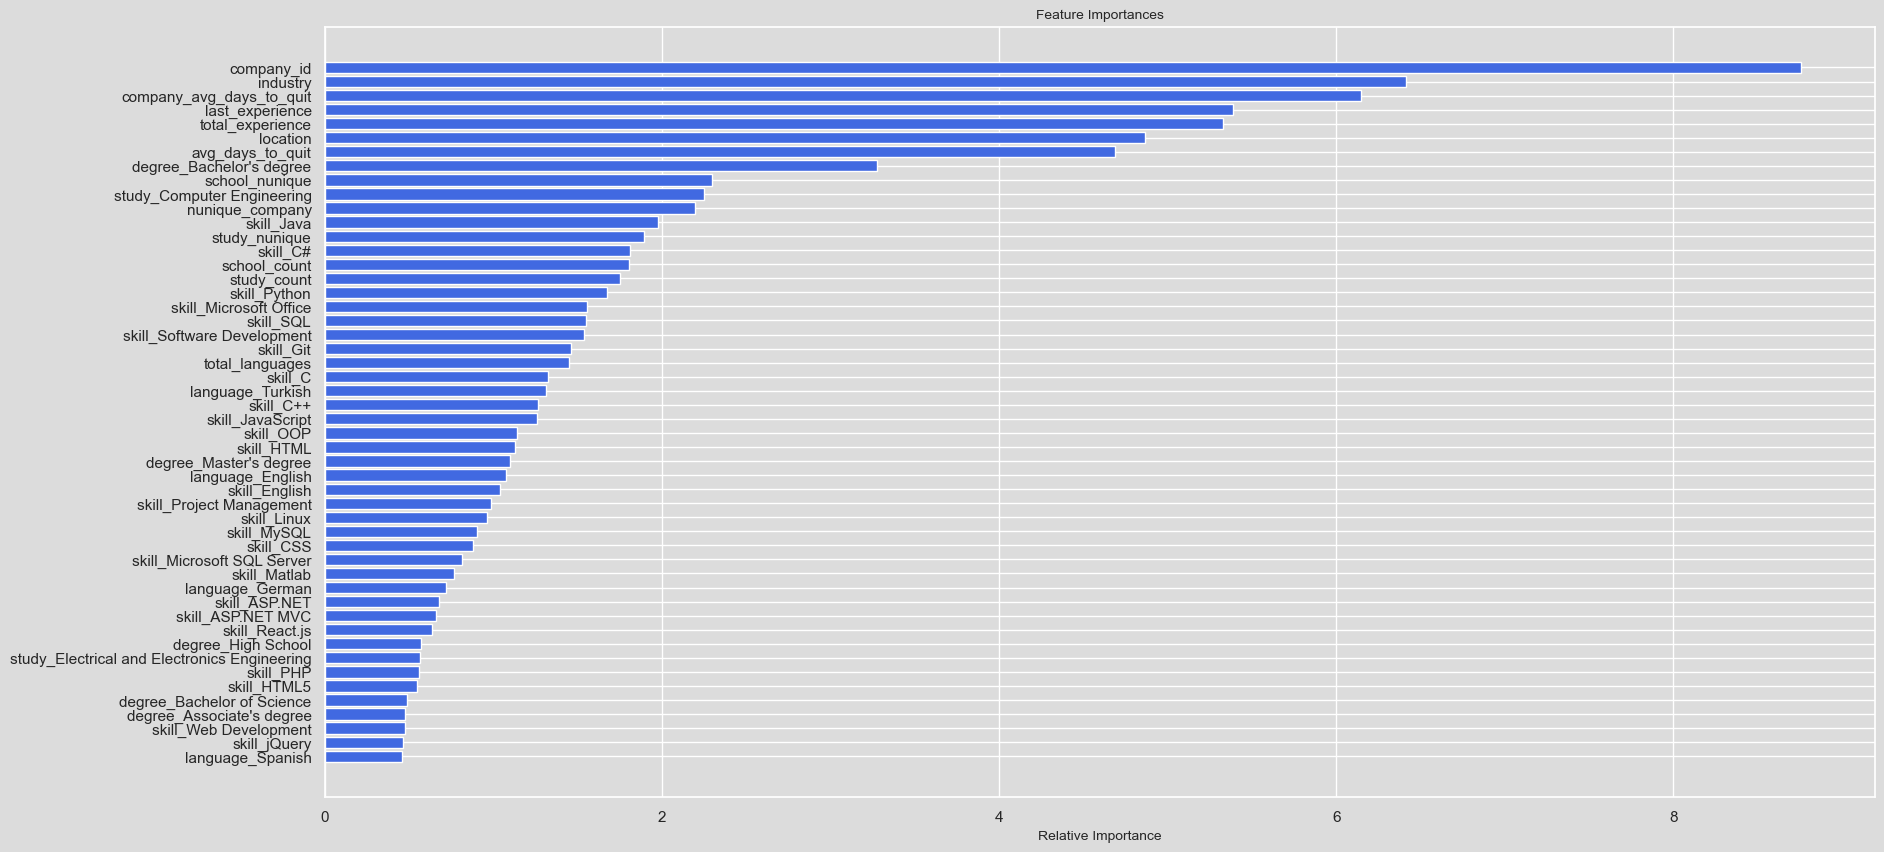

fold accuracy: 0.7806948059296142
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6462587	test: 0.6335861	best: 0.6335861 (0)	total: 179ms	remaining: 14m 53s
200:	learn: 0.8569780	test: 0.7520652	best: 0.7520652 (200)	total: 28.7s	remaining: 11m 25s
400:	learn: 0.9064325	test: 0.7630418	best: 0.7630418 (400)	total: 56.9s	remaining: 10m 52s
600:	learn: 0.9349056	test: 0.7659839	best: 0.7682471 (563)	total: 1m 26s	remaining: 10m 32s
800:	learn: 0.9531257	test: 0.7682471	best: 0.7688129 (724)	total: 1m 55s	remaining: 10m 6s
1000:	learn: 0.9650763	test: 0.7715288	best: 0.7722078 (984)	total: 2m 25s	remaining: 9m 39s
1200:	learn: 0.9727264	test: 0.7729999	best: 0.7735657 (1167)	total: 2m 53s	remaining: 9m 8s
1400:	learn: 0.9786112	test: 0.7759421	best: 0.7762815 (1367)	total: 3m 21s	remaining: 8m 38s
1600:	learn: 0.9830700	test: 0.7768473	best: 0.7774131 (1538)	total: 3m 49s	remaining: 8m 8s
1800:	learn: 0.9866009	te

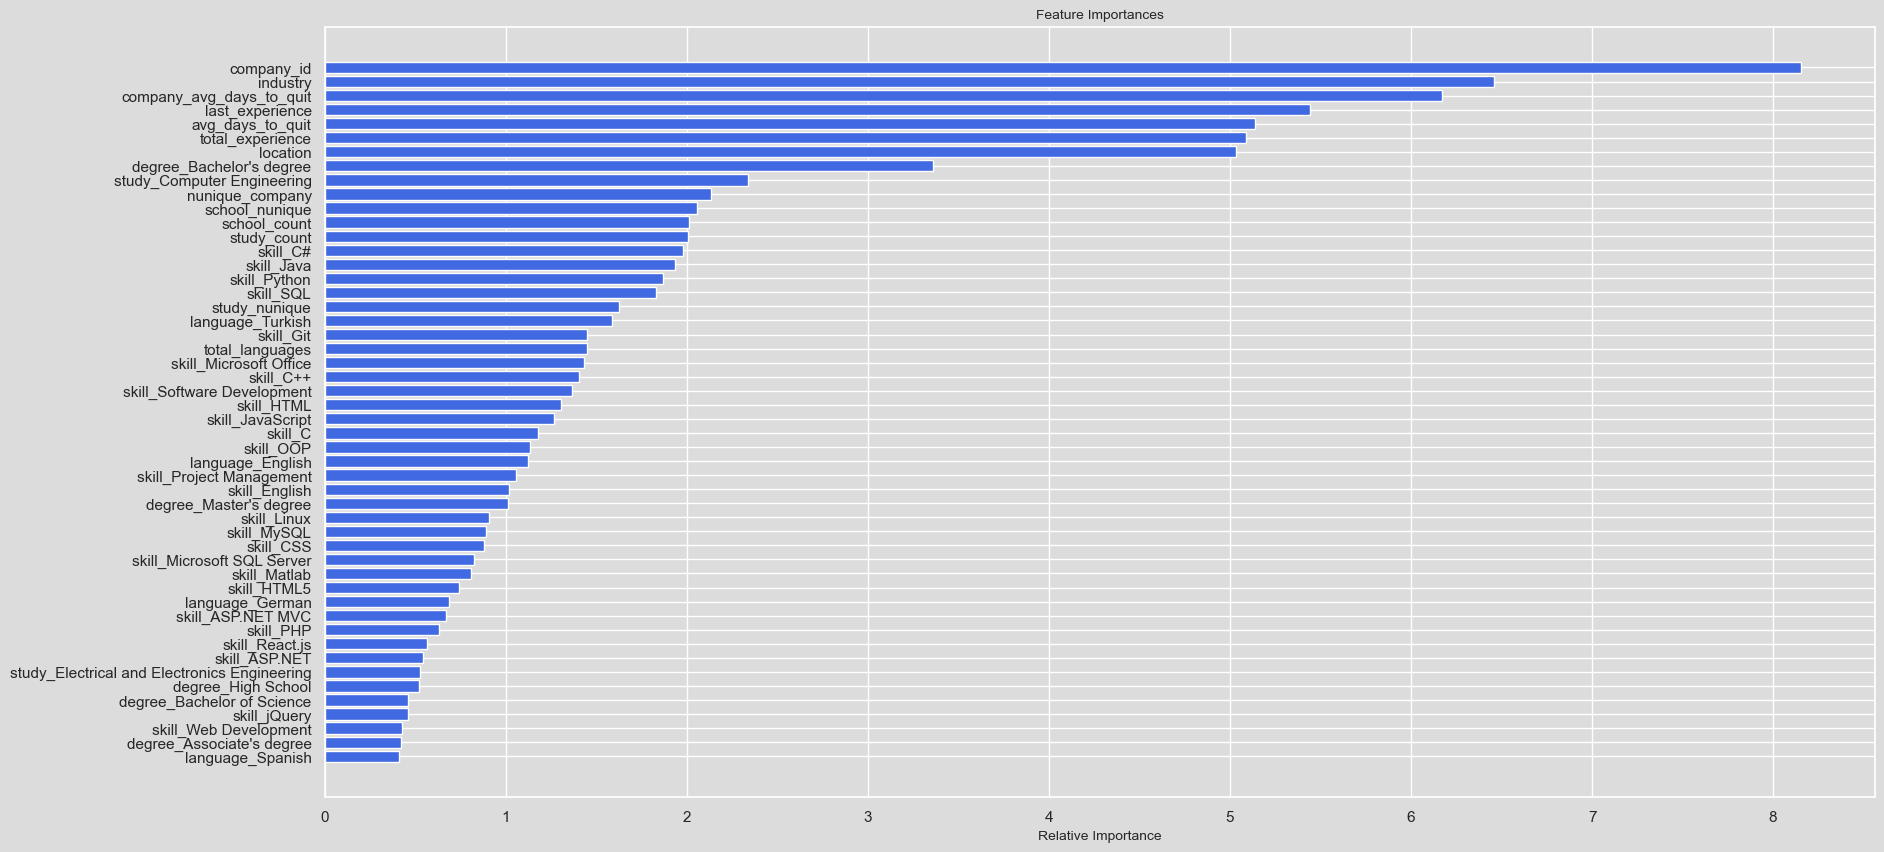

fold accuracy: 0.7778657915582211
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6184732	test: 0.6156632	best: 0.6156632 (0)	total: 42.2ms	remaining: 3m 31s
200:	learn: 0.8588145	test: 0.7498868	best: 0.7498868 (200)	total: 31.2s	remaining: 12m 24s
400:	learn: 0.9090148	test: 0.7608646	best: 0.7613173 (395)	total: 59.3s	remaining: 11m 20s
600:	learn: 0.9368083	test: 0.7672024	best: 0.7676550 (584)	total: 1m 29s	remaining: 10m 56s
800:	learn: 0.9533078	test: 0.7696922	best: 0.7707107 (767)	total: 1m 58s	remaining: 10m 21s
1000:	learn: 0.9640586	test: 0.7719556	best: 0.7726347 (995)	total: 2m 27s	remaining: 9m 47s
1200:	learn: 0.9730439	test: 0.7709371	best: 0.7736532 (1025)	total: 2m 55s	remaining: 9m 14s
1400:	learn: 0.9775706	test: 0.7710502	best: 0.7736532 (1025)	total: 3m 24s	remaining: 8m 45s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7736532368
bestIteration = 1025

Shrink model t

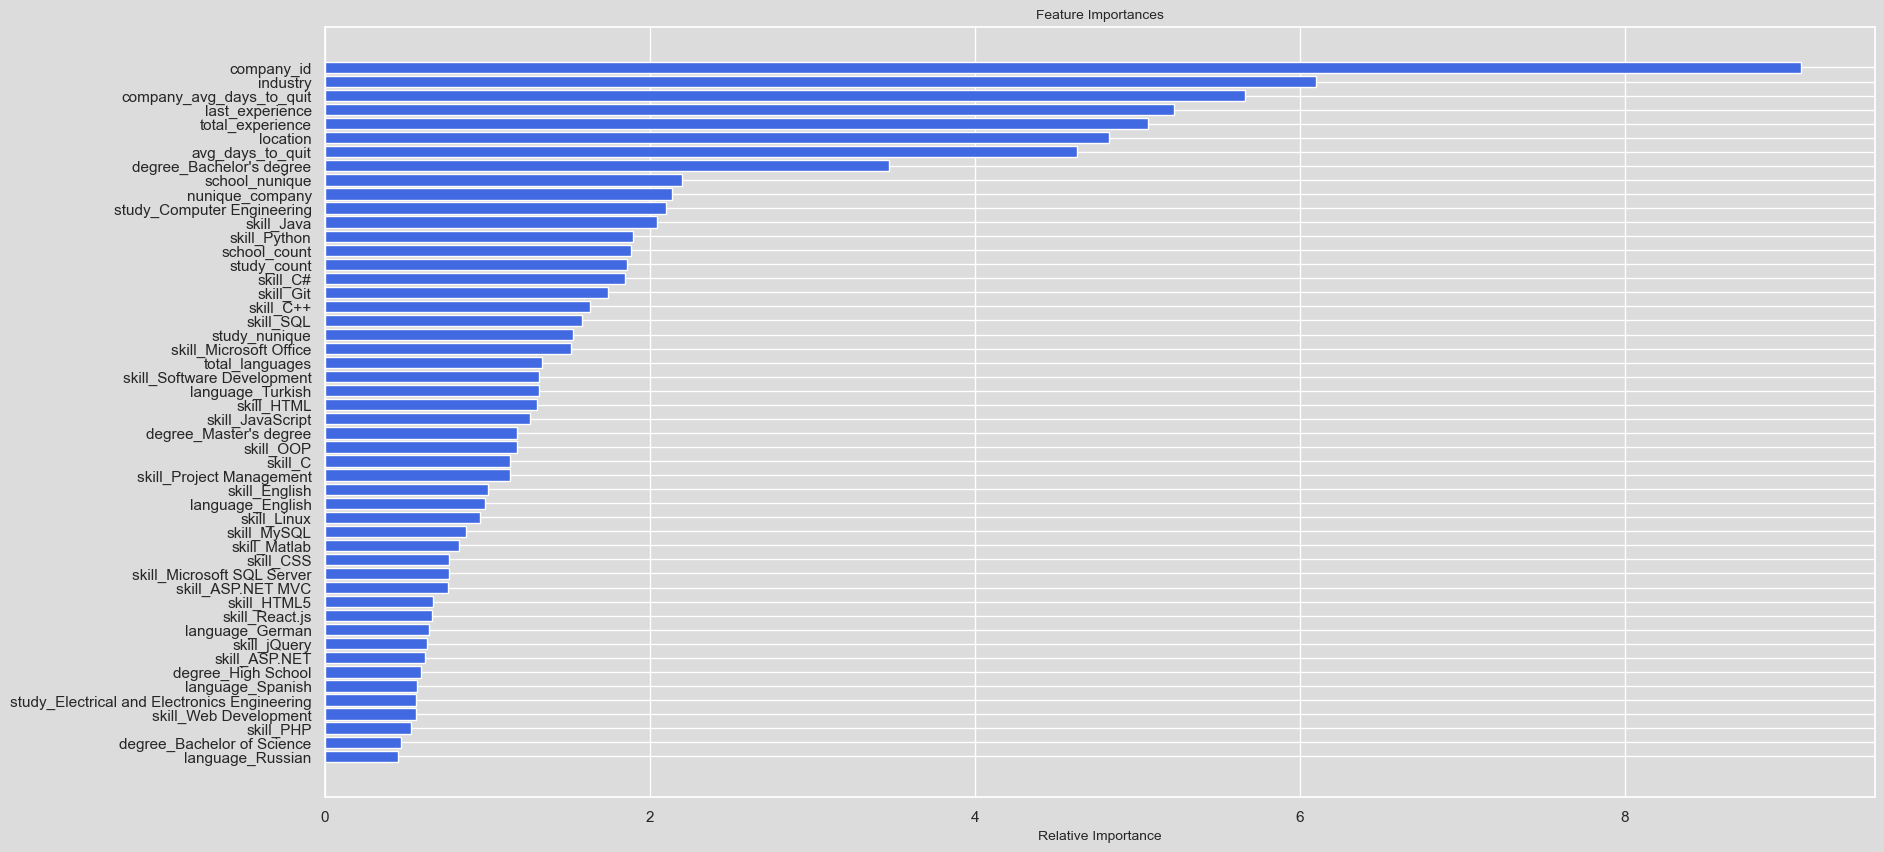

fold accuracy: 0.7736532367587143
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6531471	test: 0.6342236	best: 0.6342236 (0)	total: 211ms	remaining: 17m 32s
200:	learn: 0.8593577	test: 0.7544138	best: 0.7552060 (198)	total: 33.6s	remaining: 13m 22s
400:	learn: 0.9108028	test: 0.7636940	best: 0.7640335 (389)	total: 1m 7s	remaining: 12m 53s
600:	learn: 0.9376910	test: 0.7737664	best: 0.7737664 (599)	total: 1m 41s	remaining: 12m 20s
800:	learn: 0.9548016	test: 0.7751245	best: 0.7758035 (756)	total: 2m 15s	remaining: 11m 52s
1000:	learn: 0.9653939	test: 0.7778407	best: 0.7785197 (994)	total: 2m 50s	remaining: 11m 20s
1200:	learn: 0.9728402	test: 0.7785197	best: 0.7803305 (1153)	total: 3m 23s	remaining: 10m 44s
1400:	learn: 0.9786343	test: 0.7793119	best: 0.7803305 (1153)	total: 3m 57s	remaining: 10m 9s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7803304663
bestIteration = 1153

Shrink model

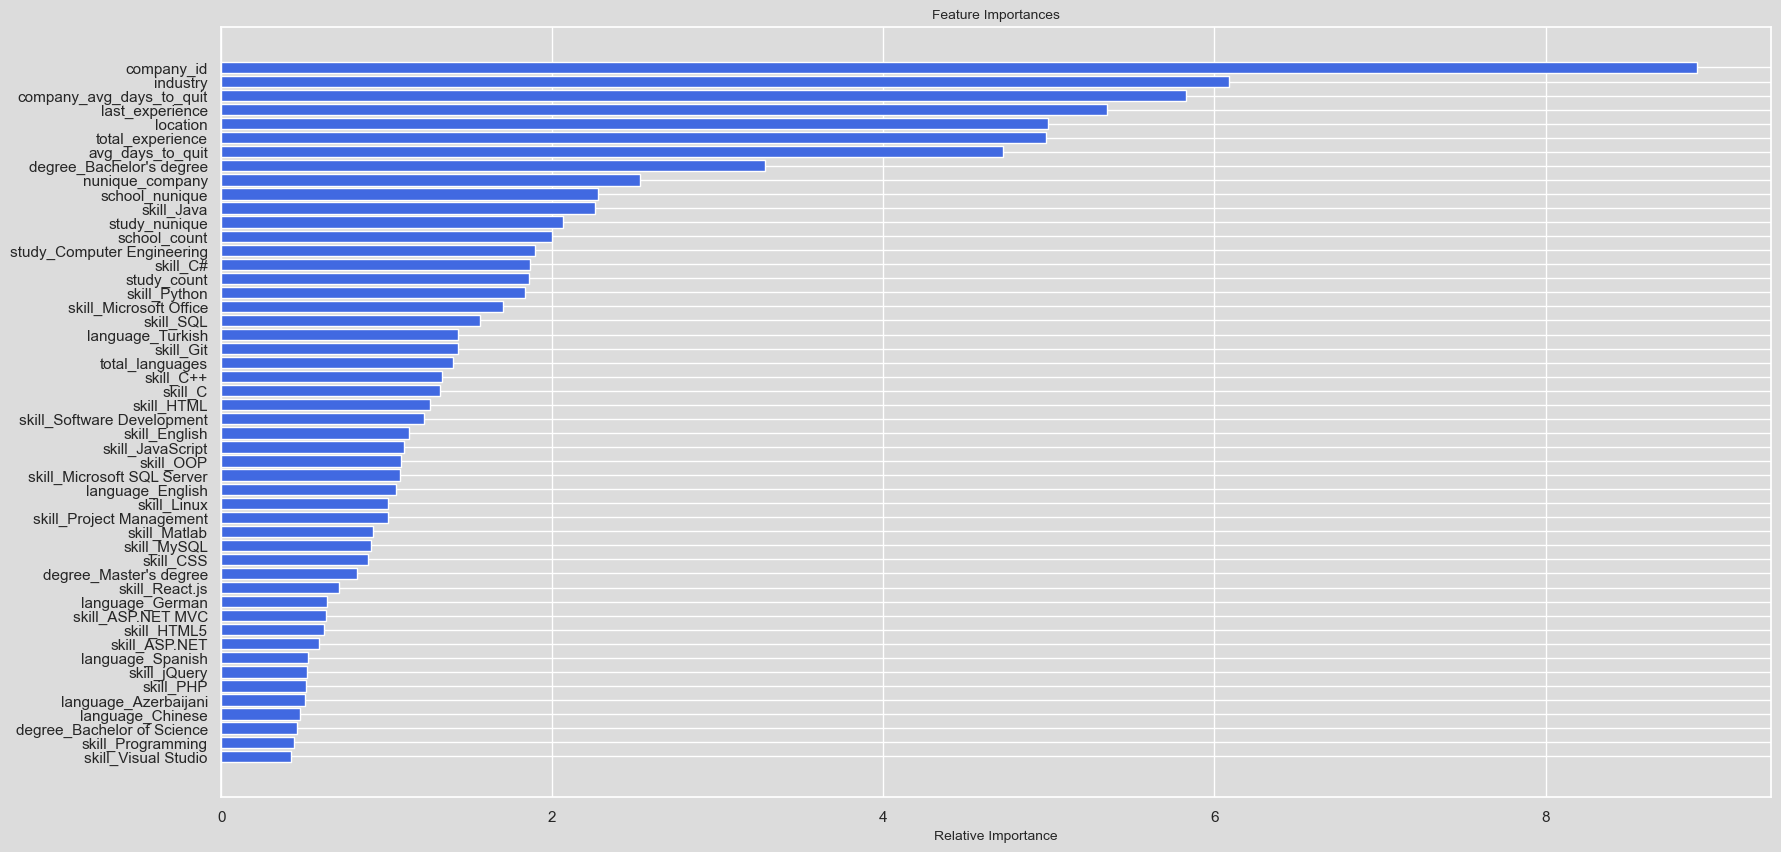

fold accuracy: 0.7803304662743322
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6187674	test: 0.6131734	best: 0.6131734 (0)	total: 27.6ms	remaining: 2m 17s
200:	learn: 0.8536768	test: 0.7409461	best: 0.7410593 (198)	total: 27.8s	remaining: 11m 3s
400:	learn: 0.9042618	test: 0.7582617	best: 0.7582617 (399)	total: 55.7s	remaining: 10m 39s
600:	learn: 0.9325080	test: 0.7605251	best: 0.7633545 (547)	total: 1m 23s	remaining: 10m 14s
800:	learn: 0.9488944	test: 0.7658443	best: 0.7667497 (778)	total: 1m 53s	remaining: 9m 55s
1000:	learn: 0.9627006	test: 0.7696922	best: 0.7696922 (1000)	total: 2m 21s	remaining: 9m 26s
1200:	learn: 0.9714370	test: 0.7685604	best: 0.7696922 (1000)	total: 2m 50s	remaining: 8m 58s
1400:	learn: 0.9766200	test: 0.7720688	best: 0.7720688 (1398)	total: 3m 18s	remaining: 8m 29s
1600:	learn: 0.9814861	test: 0.7722952	best: 0.7730874 (1415)	total: 3m 46s	remaining: 8m 1s
1800:	learn: 0.9851979	t

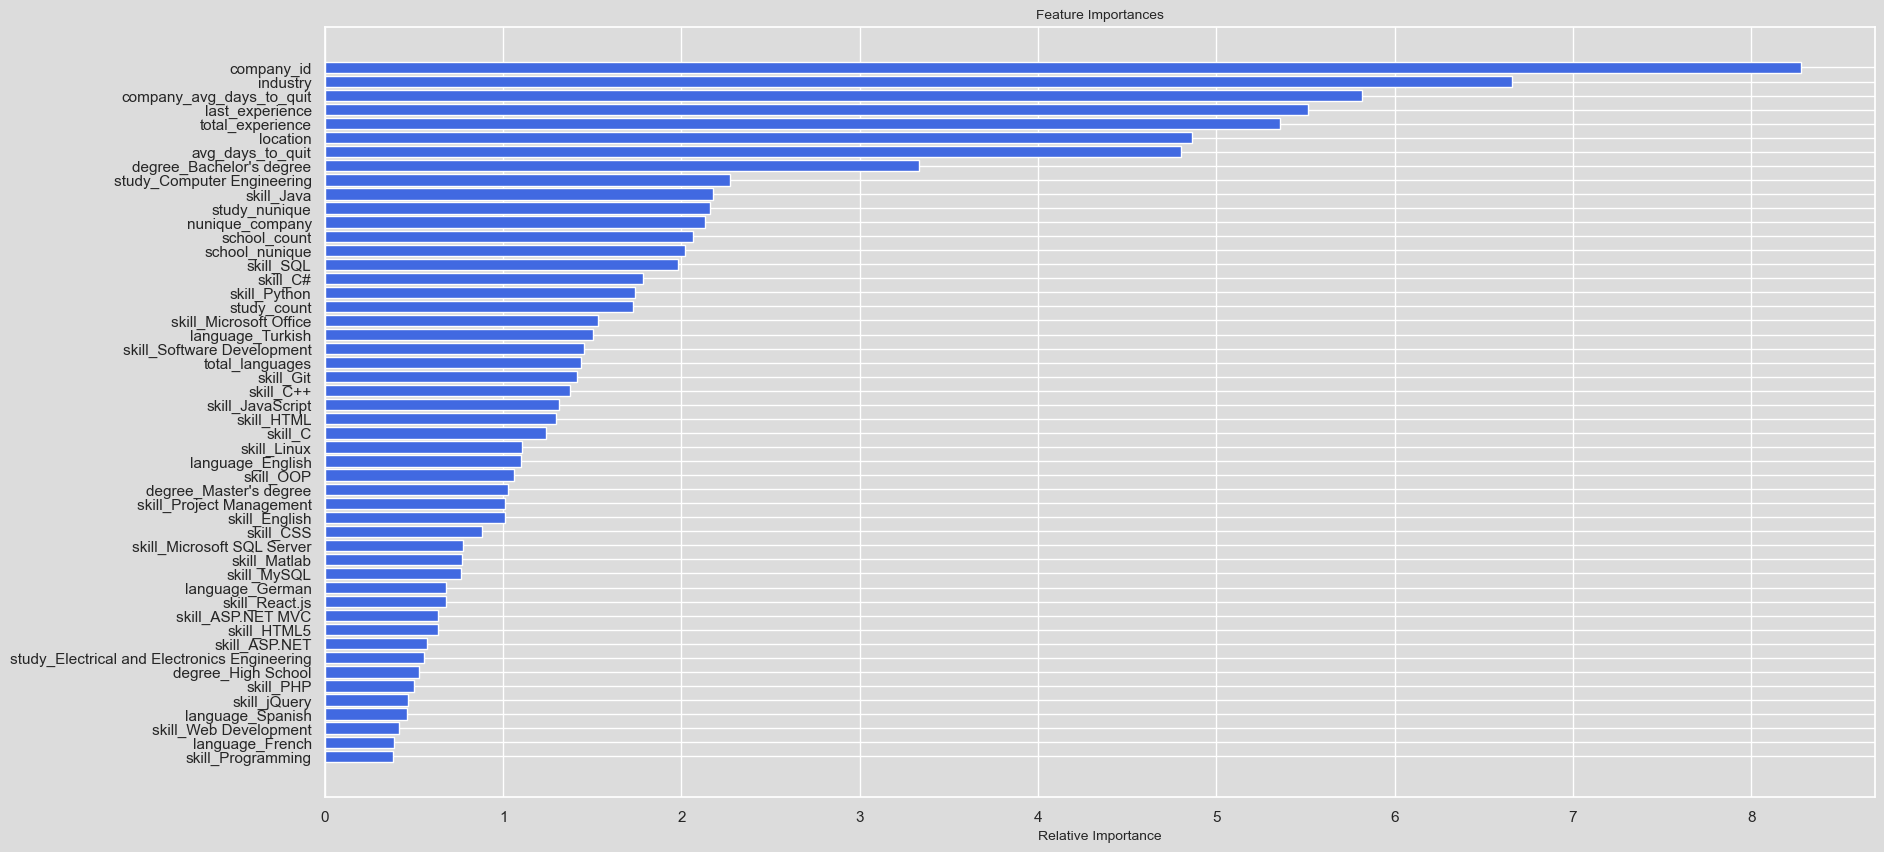

fold accuracy: 0.7781801720235401
accuracy: 0.776815858465833


In [46]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

accuracy: 0.7706293970086195

In [47]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [48]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)